In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/srivathsa/projects/voxelmorph')


import voxelmorph as vxm
import matplotlib.pyplot as plt
import neurite as ne
import os
import numpy as np
import subtle.subtle_preprocess as supre
import SimpleITK as sitk
import subtle.utils.io as suio
import subtle.subtle_metrics as su_metrics
import pydicom
from glob import glob

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

def sort_dcm(fpath):
    return int(pydicom.dcmread(fpath).InstanceNumber)

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))], key=sort_dcm)
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

def mse(imgA, imgB):
    return (np.square(imgA - imgB)).mean()

<Figure size 720x576 with 0 Axes>

In [8]:
fpath_tfiles = '/home/srivathsa/projects/studies/gad/vmorph/image_lists/nonrigid_post/test_post.txt'
test_files = vxm.py.utils.read_file_list(fpath_tfiles)
generator = vxm.generators.SubtleGadLoader(fpath_tfiles, batch_size=1, shuffle=False)
gen = vxm.generators.scan_to_scan(test_files)
sample_shape = next(gen)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

model = vxm.networks.VxmDense(
    inshape=(160, 192, 224),
    nb_unet_features=[enc_nf, dec_nf],
    bidir=False,
    use_probs=False,
    int_steps=7,
    int_downsize=2,
    src_feats=nfeats,
    trg_feats=nfeats
)

In [11]:
model.model.load_weights('/home/srivathsa/projects/studies/gad/vmorph/old_ckps/post/1180.h5')
# model.load_weights('/home/srivathsa/projects/studies/gad/vmorph/checkpoints/1360.h5')
# model.load_weights('/home/srivathsa/projects/studies/gad/vmorph/tutorial_data/brain_3d.h5')

In [26]:
# pred, defs = model.model.predict_generator(generator)
defs = model.model.predict_generator(generator)
print(defs.squeeze().shape)
print(defs)
# pred = pred[..., 0]

(5, 160, 192, 224, 3)
[[[[[-0.02709038  0.06824426 -0.18040915]
    [-0.04534573  0.07438006 -0.18884118]
    [-0.06360108  0.08051585 -0.19727321]
    ...
    [-0.05641992  0.09883893 -0.1638136 ]
    [-0.04654899  0.08998768 -0.15857694]
    [-0.03667807  0.08113643 -0.15334028]]

   [[-0.03693401  0.0746382  -0.18197325]
    [-0.05763622  0.08012404 -0.19397552]
    [-0.07833844  0.08560991 -0.20597783]
    ...
    [-0.06999839  0.09700248 -0.17086363]
    [-0.05768339  0.08931131 -0.16237117]
    [-0.04536838  0.08162013 -0.15387873]]

   [[-0.04677765  0.08103212 -0.18353733]
    [-0.06992672  0.08586803 -0.1991099 ]
    [-0.09307579  0.09070394 -0.21468246]
    ...
    [-0.08357687  0.09516603 -0.17791365]
    [-0.06881779  0.08863493 -0.16616541]
    [-0.05405869  0.08210384 -0.15441719]]

   ...

   [[-0.01773817  0.1064851  -0.14807329]
    [-0.02183926  0.1150988  -0.16059338]
    [-0.02594036  0.12371251 -0.17311347]
    ...
    [-0.02169116  0.11980314 -0.18303445]
    [-0.

(64, 75, 2)


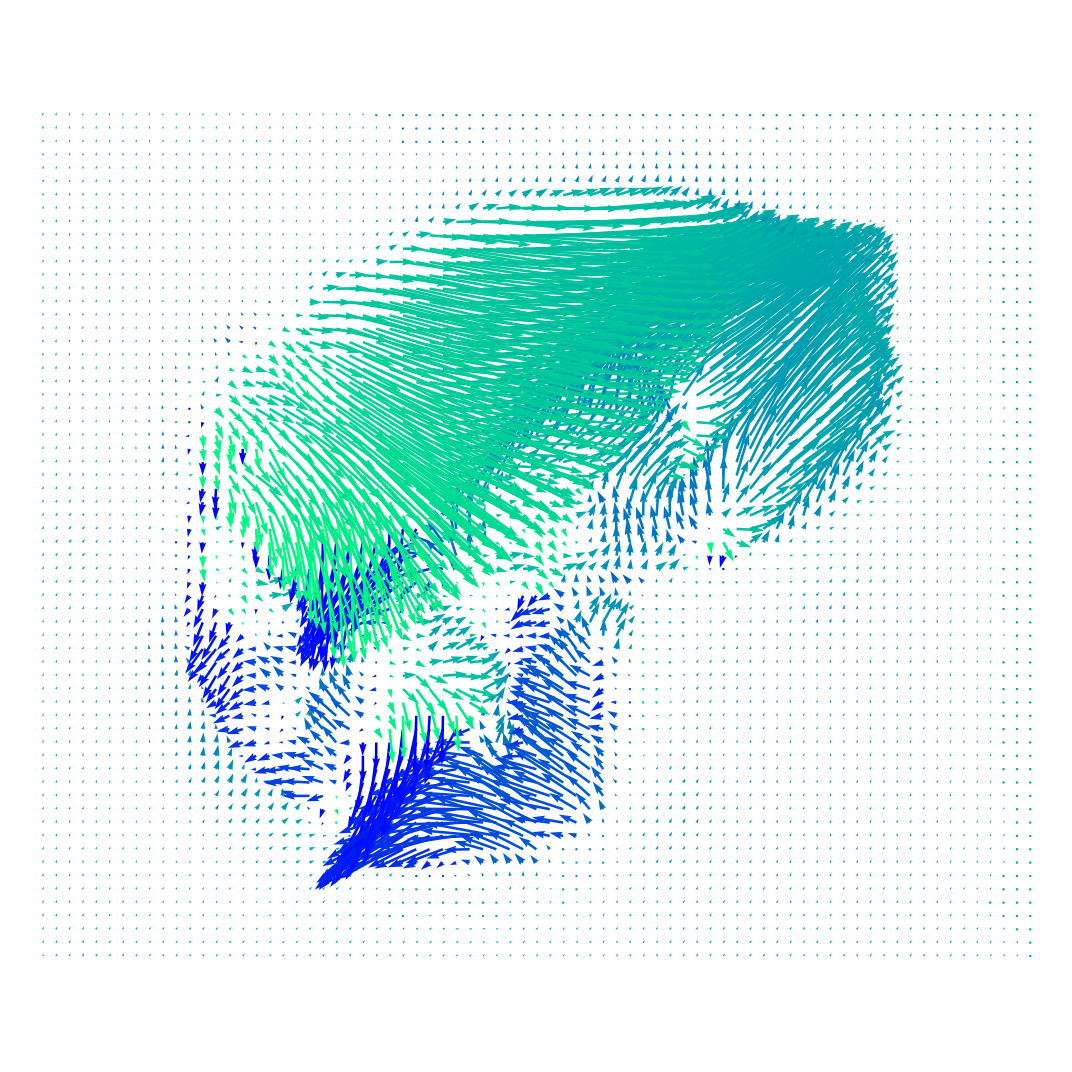

(<Figure size 1080x1080 with 1 Axes>, [<AxesSubplot:>])

In [25]:
flow = defs.squeeze()[2, 80, ::3,::3, 1:3]
print(flow.shape)
ne.plot.flow([flow], width=15)

In [ ]:
pre_con, low_con = np.load('/home/srivathsa/projects/studies/gad/vmorph/proc_data/NO103_post.npz')['data']
pre_con = np.clip(pre_con, 0, pre_con.max())
low_con = np.clip(low_con, 0, low_con.max())

diff1 = pred[0, 80] - pre_con[80]
diff1 = np.clip(diff1, 0, diff1.max())
diff2 = pre_con[80] - pred[0, 80]
diff2 = np.clip(diff2, 0, diff2.max())
# plt.imshow(np.hstack([pre_con[80], low_con[80], pred[0, 80], diff1, diff2]))
# plt.imshow(pred[2, 80] - pre_con[80])
plt.imshow(low_con[80] - pre_con[80])
# plt.imshow(np.hstack([pre_con[80], low_con[80], pred[2, 80]]))

In [ ]:
pre_con, low_con = np.load('/home/srivathsa/projects/studies/gad/vmorph/affine_data/sc/NO1.npz')['data']
pre_con = np.interp(pre_con, (pre_con.min(), pre_con.max()), (0, 1))
low_con = np.interp(low_con, (low_con.min(), low_con.max()), (0, 1))
# pre_con = np.clip(pre_con, 0, pre_con.max())
# low_con = np.clip(low_con, 0, low_con.max())

pmap = sitk.GetDefaultParameterMap('rigid')
# pmap["Transform"] = ["AffineTransform"]
sitk_reg, params = supre.register_im(pre_con, low_con, param_map=pmap)

In [ ]:
print(params[0]['TransformParameters'])

In [ ]:
plt.imshow(sitk_reg[80] - pre_con[80])

In [ ]:
mse_sitk = mse(pre_con, sitk_reg)
mse_vm = 1.294e-3

In [ ]:
print(mse_sitk)
print(mse_vm)

In [ ]:
fpath = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/vmorph_noreg/NO101.h5'
pre_con, low_con, full_con = suio.load_file(fpath, params={'h5_key': 'all'})[1].transpose(1, 0, 2, 3)

In [ ]:
plt.imshow(full_con[98])

In [ ]:
plt.imshow(np.hstack([pre_con[97], low_con[97]]))

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/vmorph/affine_data/sc/NO1.npz')['data']
plt.imshow(data[0, 98])